In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge

from rasterio.transform import Affine
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
from matplotlib_scalebar.scalebar import ScaleBar
from typing import List, Any, Dict
import os
import pyproj
import pandas as pd
import cmocean
import cmocean.cm as cmo
import cmcrameri
import cmcrameri.cm as cmc
from scipy.optimize import minimize
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as img

import sgl_processor_v03 as sgl
import sgl_utils
import geopandas as gpd

In [2]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd

settings18 = sgl.ProcessorSGLSettings.from_range("20181201", "20190331")
sgl.initialize(settings18)
metas18 = sgl.get_metadata_from_csv(settings18.season_folder, ["tile-181", "tile-182", "tile-183"])
coll18 = sgl.create_collection_from_meta(settings18, metas18)

settings19 = sgl.ProcessorSGLSettings.from_range("20191201", "20200331")
sgl.initialize(settings19)
metas19 = sgl.get_metadata_from_csv(settings19.season_folder, ["tile-181", "tile-182", "tile-183"])
coll19 = sgl.create_collection_from_meta(settings19, metas19)

settings20 = sgl.ProcessorSGLSettings.from_range("20201201", "20210331")
sgl.initialize(settings20)
metas20 = sgl.get_metadata_from_csv(settings20.season_folder, ["tile-181", "tile-182", "tile-183"])
coll20 = sgl.create_collection_from_meta(settings20, metas20)

X=====================================================
SGLProcessor started for 20181201 to 20190331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.
X=====================================================
SGLProcessor started for 20201201 to 20210331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.


In [3]:
tile = gpd.read_file(r"D:\[NOT SYNC]\ASRP_Data\shackleton\tile-181_shape.shp").to_crs(pyproj.CRS(settings20.crs_ant_str))

In [4]:
lakeextent18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_lakeextent.shp"))
drains18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_drain.shp"))
gdf_labels18 = pd.read_excel(os.path.join(settings18.season_folder, "drain_labels_v1.xlsx"))
drain_labels18 = dict(zip(gdf_labels18[gdf_labels18["window"] == 0]["criteria"], gdf_labels18[gdf_labels18["window"] == 0]["drainage"]))
positive_drains18 = [k for k, v in drain_labels18.items() if v == 1]
crevs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "crev_20181201_20190331_active_45(15).shp"))
dmgs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "S1_20181201_20190331_dmg_10.shp"))

In [5]:
lakeextent19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_lakeextent.shp"))
drains19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_drain.shp"))
gdf_labels19 = pd.read_excel(os.path.join(settings19.season_folder, "drain_labels_v1.xlsx"))
drain_labels19 = dict(zip(gdf_labels19[gdf_labels19["window"] == 0]["criteria"], gdf_labels19[gdf_labels19["window"] == 0]["drainage"]))
positive_drains19 = [k for k, v in drain_labels19.items() if v == 1]
crevs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "crev_20191201_20200331_active_45(15).shp"))
dmgs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "S1_20191201_20200331_dmg_10.shp"))

In [6]:
lakeextent20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_lakeextent.shp"))
drains20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_drain.shp"))
gdf_labels20 = pd.read_excel(os.path.join(settings20.season_folder, "drain_labels_v1.xlsx"))
drain_labels20 = dict(zip(gdf_labels20[gdf_labels20["window"] == 0]["criteria"], gdf_labels20[gdf_labels20["window"] == 0]["drainage"]))
positive_drains20 = [k for k, v in drain_labels20.items() if v == 1]
crevs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "crev_20201201_20210331_active_45(15).shp"))
dmgs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "S1_20201201_20210331_dmg_10.shp"))

In [7]:
coll = coll19
dmgs = dmgs19
settings = settings19
lakeextent = lakeextent19

In [8]:
add = gpd.read_file(r"D:\[NOT SYNC]\ASRP_Data\shackleton\add_coastline_high_res_line_v7_6.shp")
add.columns
add["surface"].unique()

shelf_lines = add[add["surface"].isin(['ice shelf and front'])]
grounding_lines = add[add["surface"].isin(['ice coastline', 'grounding line', 'ice rumples', 'rock against ice shelf', 'rock coastline'])]

xmins, ymins, xmaxs, ymaxs = [], [], [], []
for name in coll.names:
    """Tiles"""
    tile = gpd.read_file(os.path.join(settings.region_folder, name + '_shape.shp')).to_crs(pyproj.CRS(settings.crs_ant_str))
    #tile.plot(ax = ax, facecolor="none", alpha = 0.5, edgecolor = "black")
    #ax.text(tile.centroid.x, tile.centroid.y, name.split("-")[-1], rotation = -90, fontweight = "bold")

    """Ice Shelf"""
    xmin, ymin, xmax, ymax = tile.total_bounds
    xmins.append(xmin)
    ymins.append(ymin)
    xmaxs.append(xmax)
    ymaxs.append(ymax)

xmin_total = np.array(xmins).min()
ymin_total = np.array(ymins).min()
xmax_total = np.array(xmaxs).max()
ymax_total = np.array(ymaxs).max()


shelf = shelf_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total]
solid = grounding_lines.cx[xmin_total:xmax_total, ymin_total:ymax_total]

In [ ]:
target_res = 3e3

In [11]:


"""Damage"""
dmg_files_to_mosaic = []
for f in coll.dmg_files:
    dmg_files_to_mosaic.append(rasterio.open(os.path.join(settings.dmg_folder, f)))

with rasterio.open(os.path.join(settings.dmg_folder, coll.dmg_files[0])) as src:
    meta = src.meta

dmg_mosaic, dmg_mosaic_transform = merge(dmg_files_to_mosaic)
dmg_resampled = sgl_utils.resample_dataset(np.nan_to_num(dmg_mosaic[0], nan = 0), transform = dmg_mosaic_transform, target_width = dmg_mosaic.shape[-1] * 300 //target_res, target_height = dmg_mosaic.shape[-2] * 300 // target_res, mode = "average")
#dmg_resampled_norm = dmg_resampled/dmg_resampled.max()
dmg_resampled_transform = Affine(target_res, 0, dmg_mosaic_transform[2],
                            0, -target_res, dmg_mosaic_transform[5])


meta.update(
    transform = dmg_resampled_transform,
    height = dmg_resampled.shape[-2],
    width = dmg_resampled.shape[-1]
    )

filename = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "dmg.tif"])
with rasterio.open(os.path.join(settings.dmg_folder, filename), 'w', **meta) as src:
    src.write_band(1, dmg_resampled[0])


"""Active Crevasses"""
d_alpha_files_to_mosaic = []
for f in coll.delta_alpha_c_files:
    d_alpha_files_to_mosaic.append(rasterio.open(os.path.join(settings.dmg_folder, f)))
with rasterio.open(os.path.join(settings.dmg_folder, coll.delta_alpha_c_files[0])) as src:
    meta = src.meta

crev_mosaic, crev_mosaic_transform = merge(d_alpha_files_to_mosaic)

crev_active = sgl_utils.create_active_crevasses_mask(crev_mosaic, 45, 15)

crev_mask = np.zeros(crev_active.shape)
crev_mask[np.nan_to_num(crev_active, nan = -1) >= 0] = 1


crev_resampled = sgl_utils.resample_dataset(np.nan_to_num(crev_mask[0], nan = 0), transform = crev_mosaic_transform, target_width = crev_mask.shape[-1] * 300 //target_res, target_height = crev_mask.shape[-2] * 300 // target_res, mode = "average")
#crev_resampled_norm = crev_resampled / crev_resampled.max()
crev_resampled_transform = Affine(target_res, 0, crev_mosaic_transform[2],
                            0, -target_res, crev_mosaic_transform[5])


meta.update(
    transform = crev_resampled_transform,
    height = crev_resampled.shape[-2],
    width = crev_resampled.shape[-1]
    )

filename = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "crev.tif"])
with rasterio.open(os.path.join(settings.dmg_folder, filename), 'w', **meta) as src:
    src.write_band(1, crev_resampled[0])


"""Strain"""
emax_files_to_mosaic = []
for f in coll.emax_files:
    emax_files_to_mosaic.append(rasterio.open(os.path.join(settings.region_folder, f)))
with rasterio.open(os.path.join(settings.region_folder, coll.emax_files[0])) as src:
    meta = src.meta
    
emax_mosaic, emax_mosaic_transform = merge(emax_files_to_mosaic)

emax_resampled = sgl_utils.resample_dataset(np.nan_to_num(emax_mosaic, nan = 0), transform = emax_mosaic_transform, target_width = emax_mosaic.shape[-1] * 300 //target_res, target_height = emax_mosaic.shape[-2] * 300 // target_res, mode = "average")
#emax_resampled_norm = emax_resampled / emax_resampled.max()
emax_resampled_transform = Affine(target_res, 0, emax_mosaic_transform[2],
                            0, -target_res, emax_mosaic_transform[5])


meta.update(
    transform = crev_resampled_transform,
    height = crev_resampled.shape[-2],
    width = crev_resampled.shape[-1]
    )

filename = "_".join([settings.region.lower(), str(int(target_res)) + "m", "emax.tif"])
with rasterio.open(os.path.join(settings.region_folder, filename), 'w', **meta) as src:
    src.write_band(1, emax_resampled[0])

In [12]:
legend = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\legend.png")
arrow = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\arrow.png")
scale = img.imread(r"D:\[NOT SYNC]\ASRP_Data\images\scale.png")

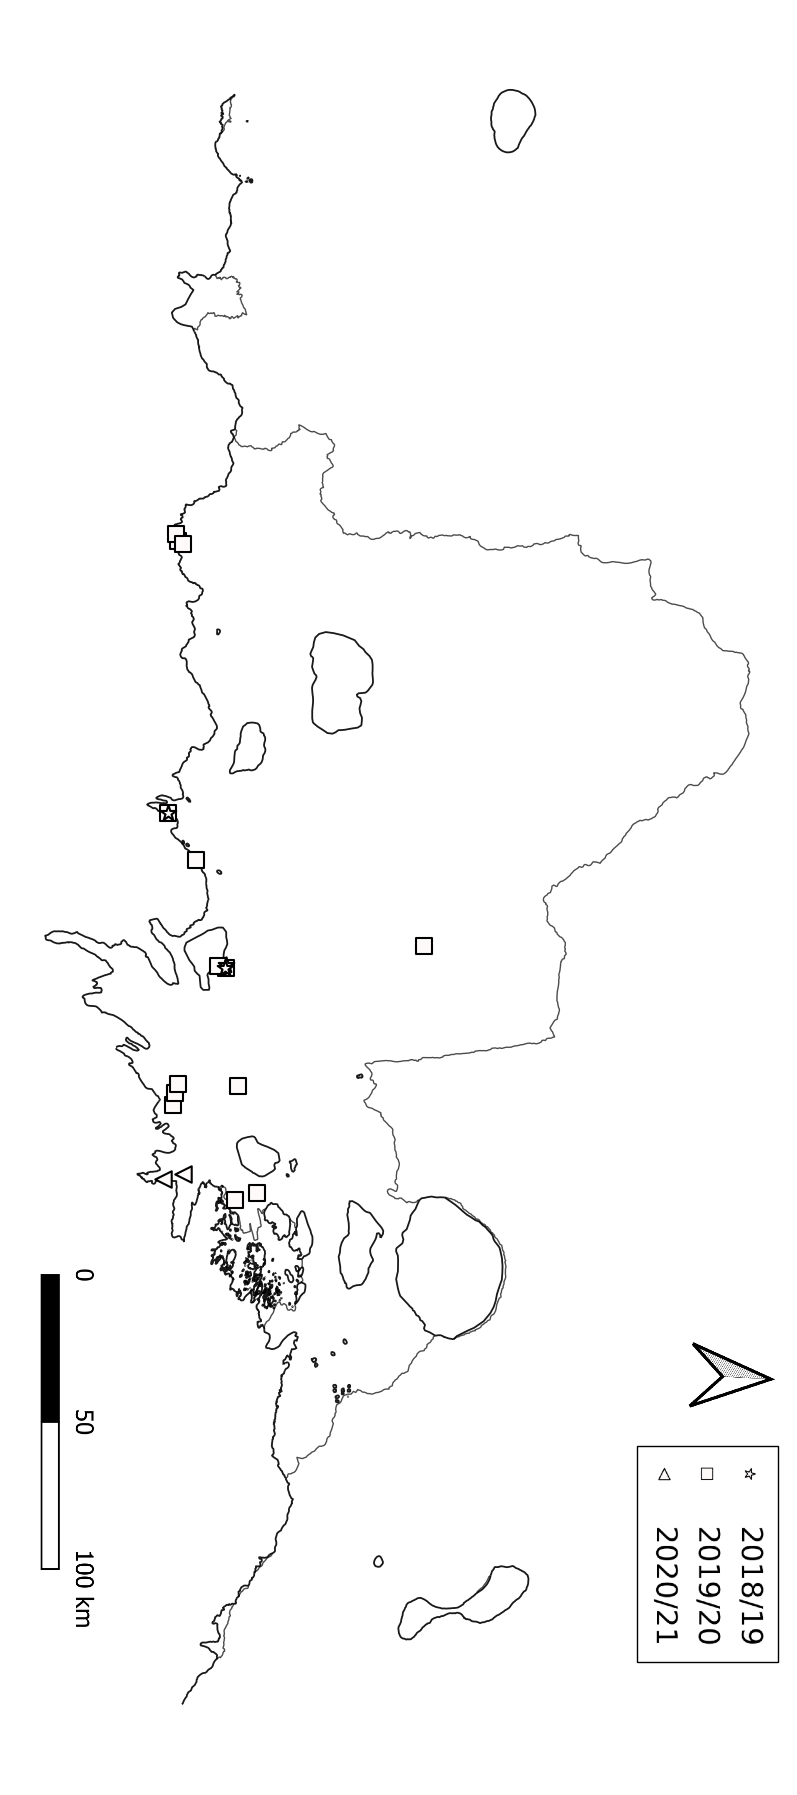

In [13]:
legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

dmg_show = dmg_resampled.copy()
dmg_show[dmg_show <= np.nanmedian(dmg_show)] = np.nan



fig, ax = plt.subplots(figsize = (10, 30))
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.3)


"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")

ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

0.00819613691419363 0.012465184162764811


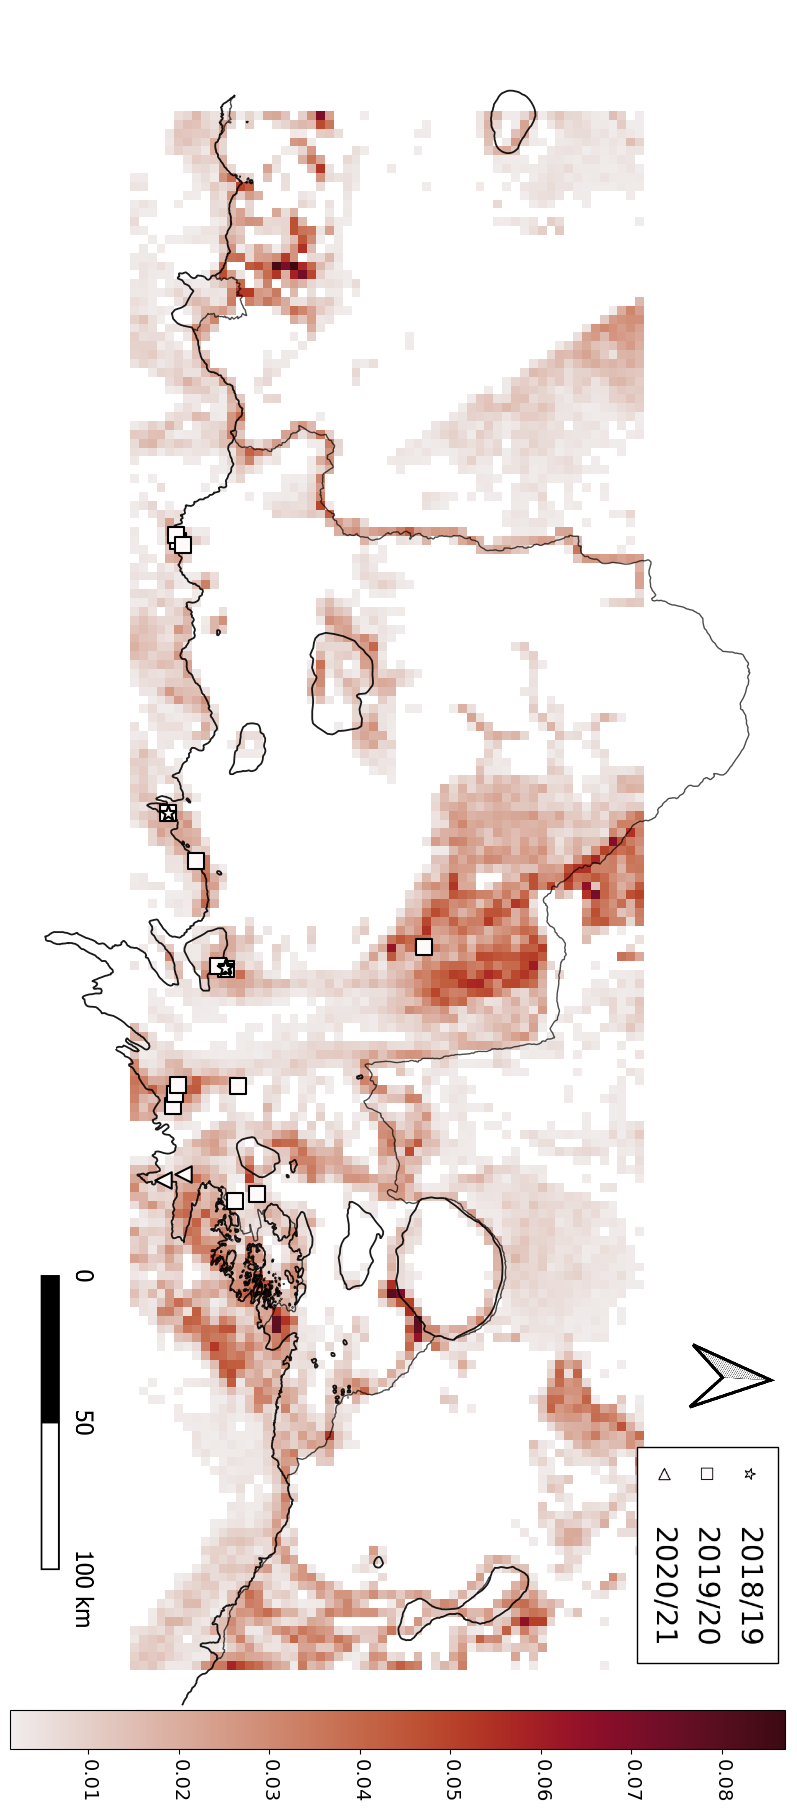

In [14]:
legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

dmg_show = dmg_resampled.copy()
dmg_show[dmg_show <= min(np.nanmean(dmg_show), np.nanmedian(dmg_show))] = np.nan
print(np.nanmedian(dmg_show), np.nanmean(dmg_show))
#dmg_show = dmg_show / dmg_resampled.max()




fig, ax = plt.subplots(figsize = (10, 30))
dmg_base = ax.imshow(dmg_show[0], cmap = cmo.amp)
plt.close()

fig, ax = plt.subplots(figsize = (10, 30))
rplt.show(dmg_show, transform = dmg_resampled_transform, ax = ax, cmap = cmo.amp)  # type: ignore
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.2)



"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")


cbar = fig.colorbar(dmg_base, ax=ax, fraction = 0.05, orientation = "horizontal", anchor = (1,6.5))
cbar.ax.tick_params(rotation=-90, labelsize=14)
ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

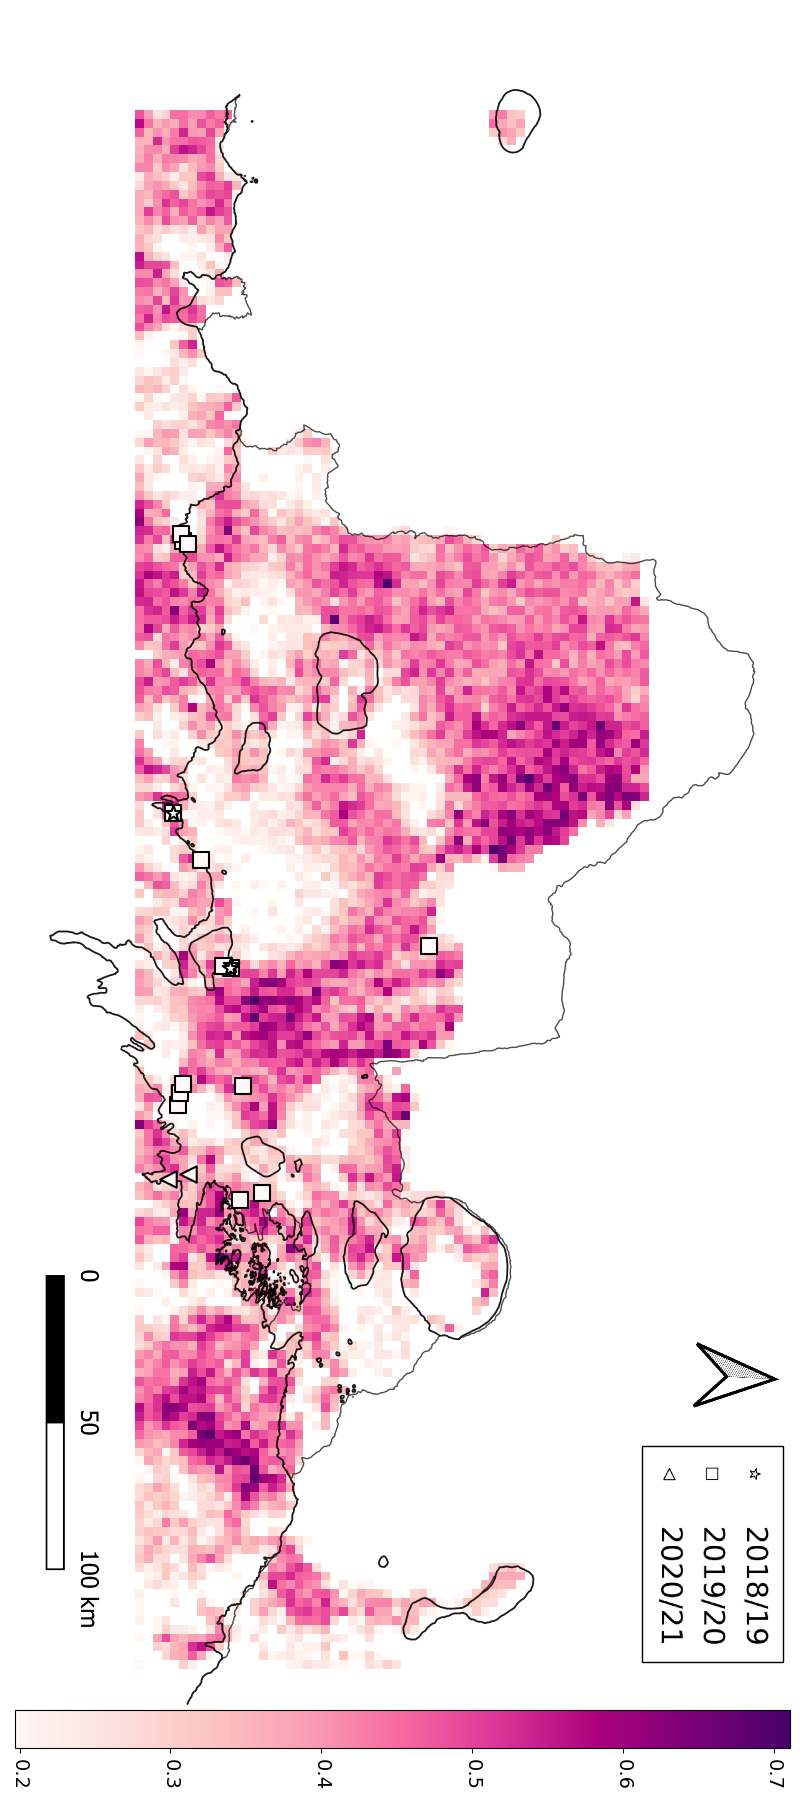

In [15]:
legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

crev_show = crev_resampled.copy()
crev_show[crev_show <= np.nanmean(crev_show)] = np.nan
#crev_show = crev_show / crev_resampled.max()
fig, ax = plt.subplots(figsize = (10, 30))
crev_base = ax.imshow(crev_show[0], cmap = "RdPu")
plt.close()

fig, ax = plt.subplots(figsize = (10, 30))
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
rplt.show(crev_show, transform = crev_resampled_transform, ax = ax, cmap = "RdPu")  # type: ignore
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.15)

"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")


cbar = fig.colorbar(crev_base, ax=ax, fraction = 0.05, orientation = "horizontal", anchor = (1,6.5))
cbar.ax.tick_params(rotation=-90, labelsize=14)
ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

-4.744038


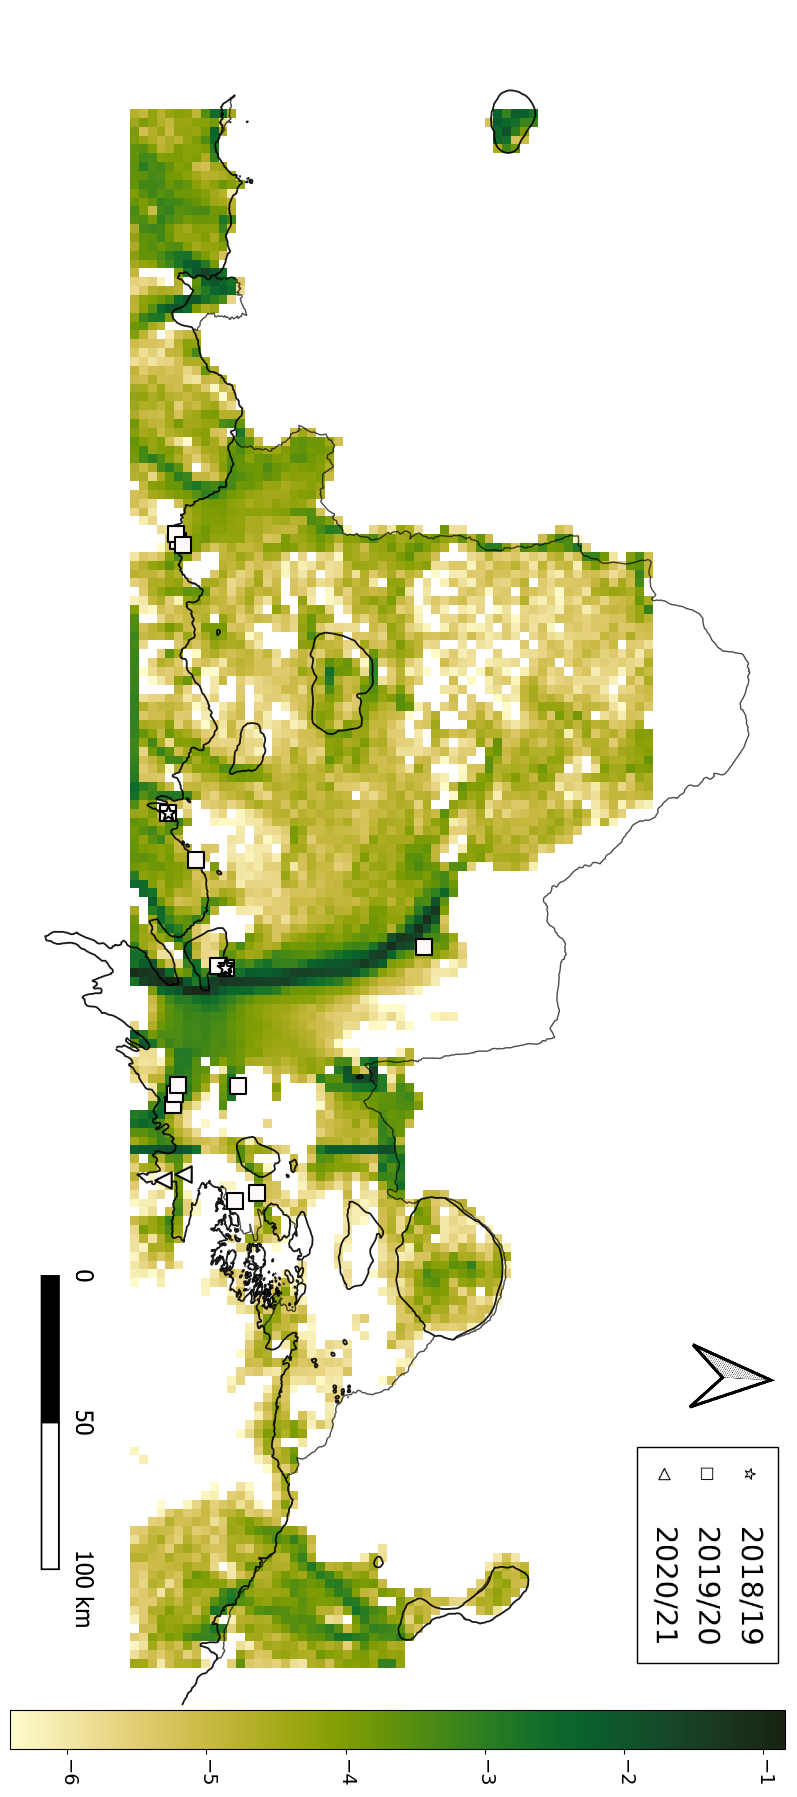

In [17]:
legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

emax_show = emax_resampled.copy()
emax_show[emax_show <= 0] = np.nan
emax_show = np.log(emax_show)
emax_show[emax_show <= np.nanmedian(emax_show) - np.nanstd(emax_show)] = np.nan
print(np.nanmedian(emax_show))
#emax_show = emax_show / emax_resampled.max()

fig, ax = plt.subplots(figsize = (10, 30))
emax_base = ax.imshow(emax_show[0], cmap = cmo.speed)
plt.close()


fig, ax = plt.subplots(figsize = (10, 30))
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
rplt.show(emax_show, transform = emax_resampled_transform, ax = ax, cmap = cmo.speed)
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.15)

"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")

cbar = fig.colorbar(emax_base, ax=ax, fraction = 0.05, orientation = "horizontal", anchor = (1,6.5))
cbar.ax.tick_params(rotation=-90, labelsize=14)
ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

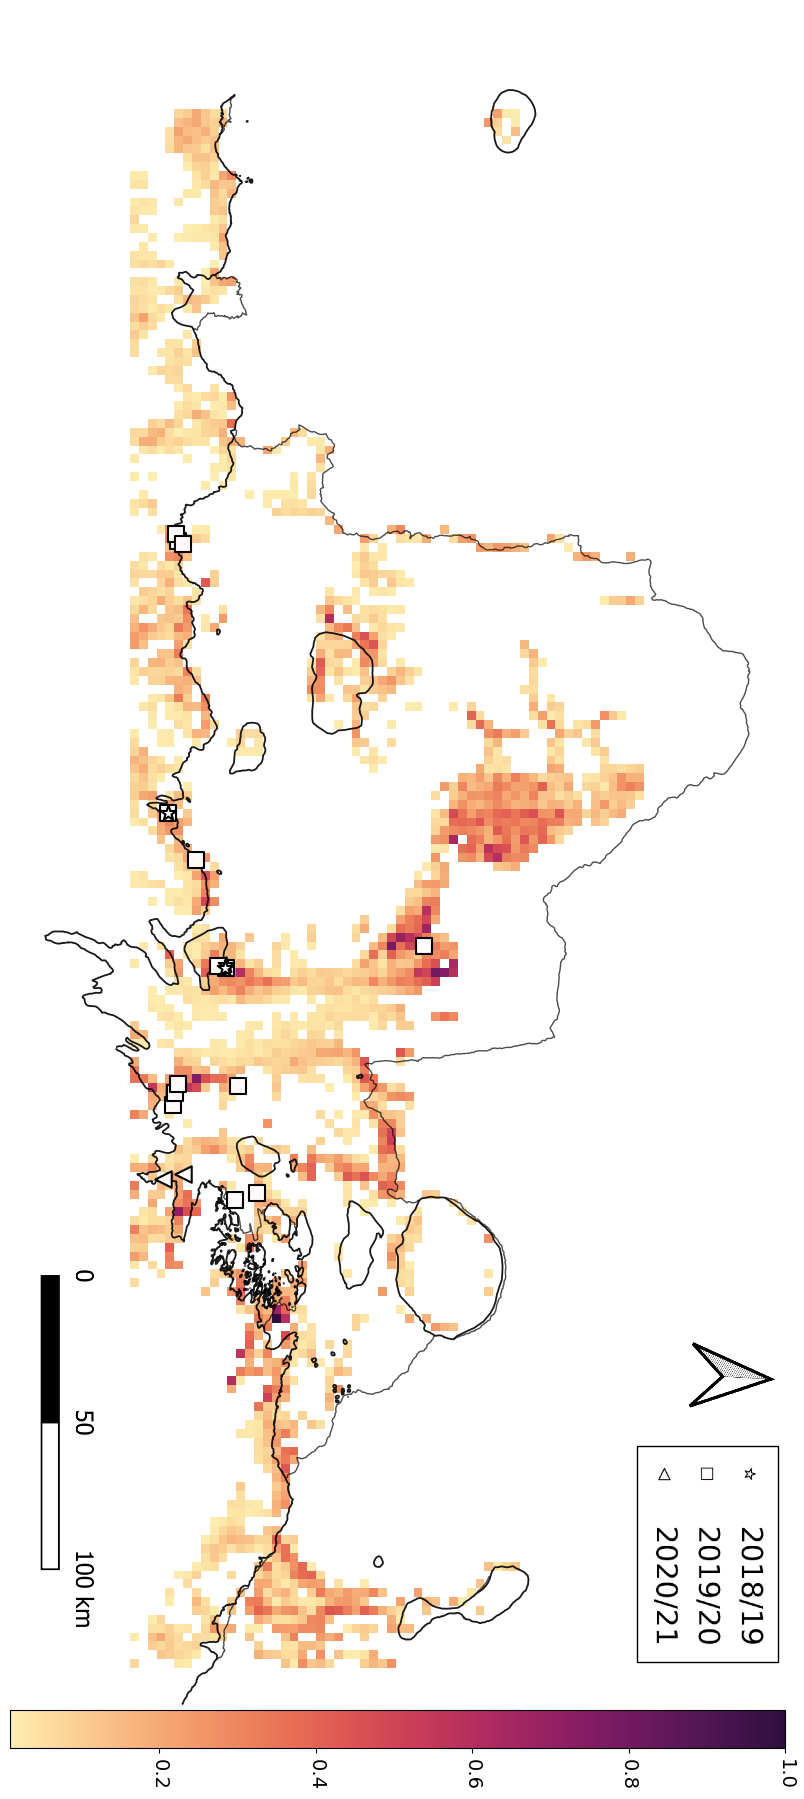

In [21]:
legend_box = OffsetImage(legend, zoom = 0.45)
legend_abox = AnnotationBbox(legend_box, xy = (0.9, 0.13), xycoords = 'axes fraction')
arrow_box = OffsetImage(arrow, zoom = 0.3)
arrow_abox = AnnotationBbox(arrow_box, xy = (0.93, 0.23), xycoords = 'axes fraction', frameon = False)
scale_box = OffsetImage(scale, zoom = 0.36)
scale_abox = AnnotationBbox(scale_box, xy = (0.08, 0.19), xycoords = 'axes fraction', frameon = False)

strain_mask = np.ones(emax_show.shape)
strain_mask[np.nan_to_num(emax_show, nan = 999) == 999] = np.nan
v = dmg_show * crev_show * strain_mask[:,:,:-1]#(-1) / emax_show[:,:,:-1] #strain_mask[:,:,:-1]
combo = v  / np.nanmax(v)
combo[combo <= 0] = np.nan

meta.update(
    transform = dmg_resampled_transform,
    height = dmg_show.shape[-2],
    width = dmg_show.shape[-1]
    )

filename = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "weak.tif"])
with rasterio.open(os.path.join(settings.dmg_folder, filename), 'w', **meta) as src:
    src.write_band(1, combo[0])


fig, ax = plt.subplots(figsize = (10, 30))
weak_base = ax.imshow(combo[0], cmap = cmo.matter)
plt.close()

fig, ax = plt.subplots(figsize = (10, 30))
shelf.plot(ax = ax, facecolor="none", edgecolor='black', lw=1, alpha = 0.7)
solid.plot(ax = ax, facecolor="none", edgecolor='black', lw=1.3, alpha = 0.9)
rplt.show(combo, transform = emax_resampled_transform, ax = ax, cmap = cmo.matter)
#lakeextent19.buffer(200).plot(ax = ax, markersize = 60, color = "deepskyblue", alpha = 0.2)

"""true positive"""  
drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)].centroid.plot(ax = ax, marker = "s", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 100, label = f"{coll19.rangestart[0:4]}/{coll19.rangeend[2:4]}")
drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)].centroid.plot(ax = ax, marker = "*", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 102, label = f"{coll18.rangestart[0:4]}/{coll18.rangeend[2:4]}")
drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)].centroid.plot(ax = ax, marker = "<", markersize = 140, linewidth = 1.5, facecolor="snow", edgecolor="black", zorder = 101, label = f"{coll20.rangestart[0:4]}/{coll20.rangeend[2:4]}")

#handles, labels = plt.gca().get_legend_handles_labels()
#order = [1,0,2]
#lgnd = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "lower right", prop={'size': 40}, framealpha = 1)
#for handle in lgnd.legendHandles:
#    handle.set_sizes([240])

cbar = fig.colorbar(weak_base, ax=ax, fraction = 0.05, orientation = "horizontal", anchor = (1,6.5))
cbar.ax.tick_params(rotation=-90, labelsize=14)
ax.add_artist(legend_abox)
ax.add_artist(arrow_abox)
ax.add_artist(scale_abox)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

lakes


d:\Programme\Anaconda\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


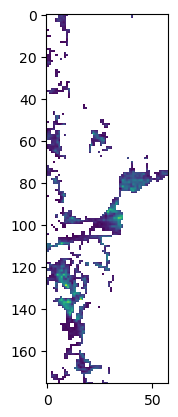

In [131]:
def get_value(row, src):
    center = row["geometry"].centroid
    value = [v for v in src.sample([(center.x, center.y)])][0][0]
    if not value > 0:
        #print(0)
        return 0
    return [v for v in src.sample([(center.x, center.y)])][0][0]

fname = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "weak.tif"])
with rasterio.open(os.path.join(settings.dmg_folder, filename)) as src:
    lakes = lakeextent19[lakeextent19.area > 54000]
    alldrains = pd.concat([drains18[(drains18["criteria"].isin(positive_drains18)) & (drains18["window"] == 0)], drains19[(drains19["criteria"].isin(positive_drains19)) & (drains19["window"] == 0)], drains20[(drains20["criteria"].isin(positive_drains20)) & (drains20["window"] == 0)]])
    alldrains["weak"] = alldrains.apply(get_value, axis = 1, src = src)
    alldrains = alldrains[alldrains["window"] == 0]
    print("lakes")
    lakes["weak"] = lakes.apply(get_value, axis = 1, src = src)
    rplt.show(src.read())

def get_weakness(row, exponents):
    return row["dmg"]**exponents[0] * row["crev"]**exponents[1] * row["emax"]**exponents[2]
    
def fun(x, drains):
    return -1 * drains.apply(get_weakness, axis = 1, exponents = x).mean(skipna = True)

In [122]:
test = pd.concat([alldrains, lakes])
test["cat"] = "no"
test.loc[test["type"].isin(["drain", "shrink"]), "cat"] = "yes"
test.reset_index(inplace = True)

In [107]:
print(alldrains["weak"].mean())
print(lakes["weak"].mean())

0.24365403356128618
0.17231465087983389
